# scAutoQC workflow tutorial

<img src="scautoqc_logo.png" alt="scautoqc_logo" width="200"/>

In [1]:
import scanpy as sc
import sctk

sc.settings.set_figure_params(dpi=80)

This notebook will show how to apply SCTK's automatic QC workflow, scAutoQC. The process has four steps:

 - `sctk.calculate_qc()` computes QC measures
 - `sctk.cellwise_qc()` performs cell-level QC calling
 - `sctk.generate_qc_clusters()` creates QC-space clusters of cells
 - `sctk.clusterwise_qc()` computes cluster-wide statistics of cell quality

It is recommended to run scAutoQC on a per-sample basis. The workflow offers a utility function `sctk.multi_resolution_cluster_qc()` to attempt clustering with multiple resolutions and draw broader automated conclusions, which is likely to be of use when faced with multiple samples to process. This leads to a simplified analysis flow of:

```python
sctk.calculate_qc()
sctk.cellwise_qc()
sctk.multi_resolution_cluster_qc()
```

Let's take a closer look at what each step in the process does, using Scanpy's PBMC object as input.

In [2]:
adata = sc.datasets.pbmc3k()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

This object features raw counts for some PBMC data, and nothing else for now. We can use `sctk.calculate_qc()` to automatically flag some common technical features (the defaults are human mitochondrial, ribosomal and hemoglobin genes) and subsequently use `sc.pp.calculate_qc_metrics()` to compute their percentages in each cell, along with standard measures like the number of genes and counts.

In [3]:
sctk.calculate_qc(adata)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'

You can see the `.obs` of the object populated with the QC measures we just generated.

The second step of the scAutoQC workflow involves determining which of the cells pass QC individually.

In [4]:
sctk.cellwise_qc(adata)
adata

n_counts: [959.4421576429211, 15844.0029296875], 2563/2700 passed
n_genes: [320.5358429786537, 3421.998779296875], 2678/2700 passed
percent_mito: [0.0, 5.943145075272779], 2674/2700 passed
percent_ribo: [13.568207997582016, 51.07162303563632], 2627/2700 passed
percent_hb: [0.0, 0.002321736026317521], 2375/2700 passed
2184/2700 pass


AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'cell_passed_qc'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    uns: 'scautoqc_ranges'

There's now a `cell_passed_qc` column in `.obs` which features per-cell QC calls.

In [5]:
adata.obs['cell_passed_qc'].sum()

2184

There's also `adata.uns['scautoqc_ranges']` which captures the inferred range print-out displayed as the function runs.

In [6]:
adata.uns['scautoqc_ranges']

,low,high
n_counts,959.442158,15844.00293
n_genes,320.535843,3421.998779
percent_mito,0.0,5.943145
percent_ribo,13.568208,51.071623
percent_hb,0.0,0.002322


Controlling the desired QC thresholds requires a bit of explanation.

Under the hood, `sctk.cellwise_qc()` models each of the specified QC metrics as a Gaussian mixture model, with the model proposing possible low and high value cutoffs at points where the probability density function of the mixture falls below a threshold (0.05 by default). The function is written to allow robust filtering, requiring a specific formatting of `metrics`. The default values are stored in `sctk.default_metric_params_df`:

In [7]:
sctk.default_metric_params_df

,min,max,scale,side,min_pass_rate
n_counts,1000.00,NaN,log,min_only,0.10
n_genes,100.00,NaN,log,min_only,0.10
percent_mito,0.01,20.0,log,max_only,0.10
percent_ribo,0.00,100.0,log,both,0.10
percent_hb,NaN,1.0,log,max_only,0.10
percent_soup,NaN,5.0,log,max_only,0.10
percent_spliced,50.00,97.5,log,both,0.10
scrublet_score,NaN,0.3,linear,max_only,0.95


The variable is a data frame, with rows named after computed QC metrics present in the `.obs` of the input object. Values absent from `.obs` will get skipped (so in our case, `percent_soup`, `percent_spliced` and `scrublet_score` all got bypassed when we ran the function). The five columns control the input to the GMM and subsequent filtering behaviour:

 - **`min`**: the minimum value to use in modelling the distribution; values lower than this will be skipped; set to `np.nan` to use the encountered minimum
 - **`max`**: the maximum value to use in modelling the distribution; values higher than this will be skipped; set to `np.nan` to use the encountered maximum
 - **`scale`**: `"log"` to log-transform the QC metric values prior to modelling, `"linear"` to keep the values un-transformed
 - **`side`**: `"min_only"` to only perform filtering of low values, `"max_only"` to only perform filtering of high values, `"both"` to perform filtering from both sides
 - **`min_pass_rate`**: the minimum proportion of cells that need to pass the filtering on this feature; if the fraction is too low, the GMM is discarded and the QC values are thresholded based on the provided minimum/maximum

As the function goes along, it prints out the actual QC metric value ranges it used in filtering, and how many cells fall within that range. For example, notice how we specified a 100-gene minimum for the modelling, but the proposed data-driven cutoff ends up being 320.

Let's try out modifying the `metrics` values by taking the default data farme, removing the three measures absent from our object, and increasing the `n_genes` minimum to 500.

In [8]:
metrics = sctk.default_metric_params_df.loc[["n_counts",
    "n_genes",
    "percent_mito",
    "percent_ribo",
    "percent_hb"], :]

metrics.loc["n_genes", "min"] = 500
metrics

,min,max,scale,side,min_pass_rate
n_counts,1000.00,NaN,log,min_only,0.1
n_genes,500.00,NaN,log,min_only,0.1
percent_mito,0.01,20.0,log,max_only,0.1
percent_ribo,0.00,100.0,log,both,0.1
percent_hb,NaN,1.0,log,max_only,0.1


Let's re-run `sctk.cellwise_qc()` with these parameters.

In [9]:
sctk.cellwise_qc(adata, metrics=metrics)

n_counts: [959.4421576429211, 15844.0029296875], 2563/2700 passed
n_genes: [495.3027116195289, 3421.998779296875], 2486/2700 passed
percent_mito: [0.0, 5.943145075272779], 2674/2700 passed
percent_ribo: [13.568207997582016, 51.07162303563632], 2627/2700 passed
percent_hb: [0.0, 0.002321736026317521], 2375/2700 passed
2118/2700 pass


The gene count filtering is different now, as expected.

The third step of the QC workflow is to cluster the cells based on specified metrics, performing a quick Scanpy analysis using the metrics as features. This creates groups of cells that have similar QC profiles.

In [10]:
#present as columns in obs of the object
metrics_list = ["log1p_n_counts", "log1p_n_genes", "percent_mito", "percent_ribo", "percent_hb"]
sctk.generate_qc_clusters(adata, metrics = metrics_list)
adata

/home/jovyan/my-conda-envs/sctk/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'cell_passed_qc', 'qc_cluster'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    uns: 'scautoqc_ranges'
    obsm: 'X_umap_qc'

There's now an `.obs` column called `qc_cluster`, and an embedding called `X_umap_qc`. Let's take a look!

/home/jovyan/my-conda-envs/sctk/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


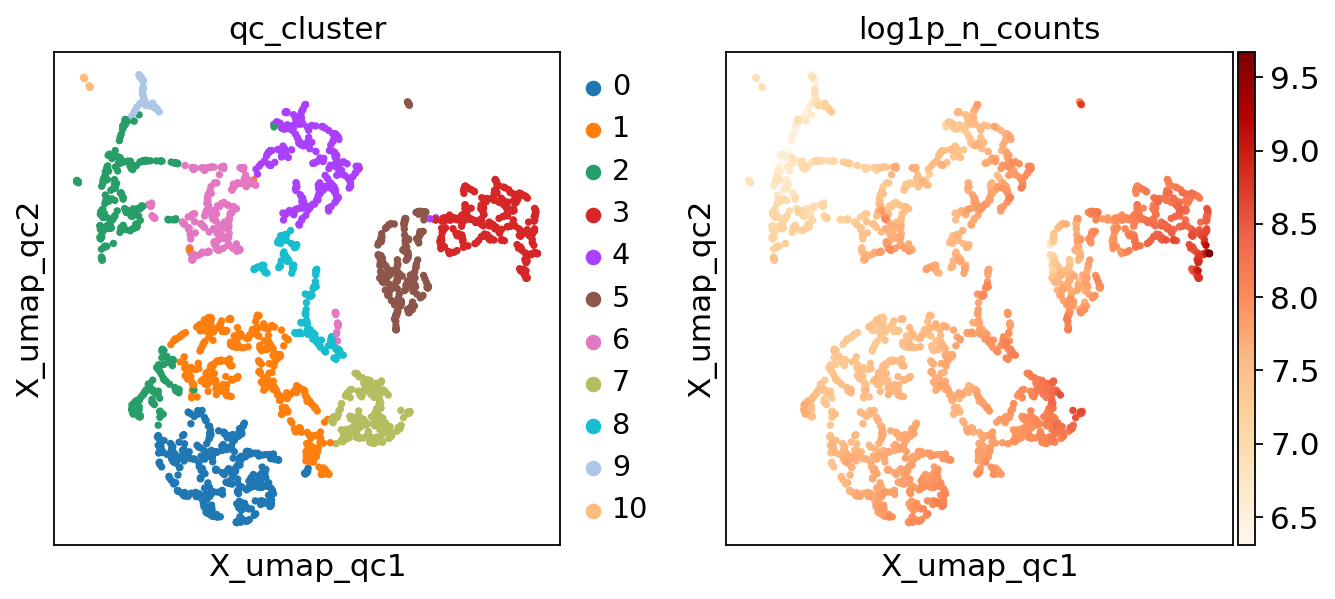

In [11]:
sc.pl.embedding(adata, "X_umap_qc", color=["qc_cluster", "log1p_n_counts"], color_map="OrRd")

The final step of the scAutoQC workflow determines computes a fraction of passing cells for each cluster. If a cluster has a high enough fraction of passing cells (controlled via the `threshold` parameter, default 0.5), it's deemed to be a good QC cluster.

You can use your own per-cell QC calls here rather than the ones provided by `sctk.cellwise_qc()` if desired, just specify which `.obs` column to take via the `cell_qc_key` argument.

In [12]:
sctk.clusterwise_qc(adata)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'cell_passed_qc', 'qc_cluster', 'cluster_passed_qc'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    uns: 'scautoqc_ranges', 'qc_cluster_colors'
    obsm: 'X_umap_qc'

There's now a `cluster_passed_qc` column. Let's take a look how it compares to the cell level QC.

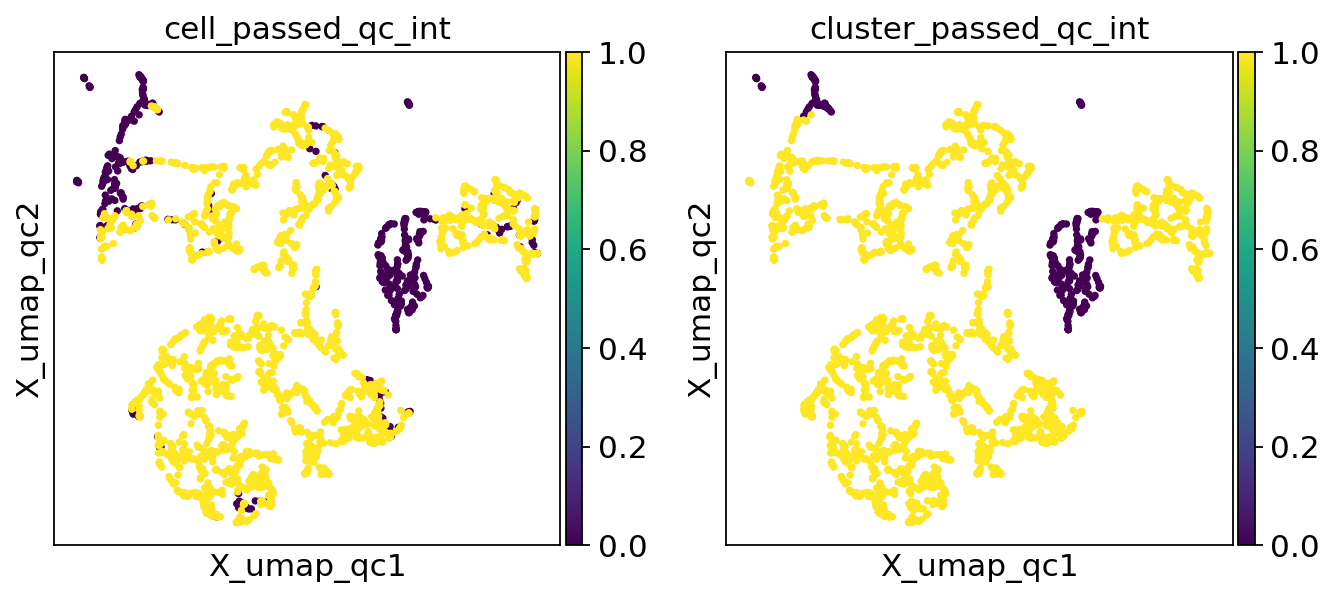

In [13]:
#this won't be necessary in scanpy 1.10.0, booleans will become directly plottable
for col in ['cell_passed_qc', 'cluster_passed_qc']:
    adata.obs[col+"_int"] = adata.obs[col].astype(int)
sc.pl.embedding(adata, "X_umap_qc", color=["cell_passed_qc_int", "cluster_passed_qc_int"])

We seem to get a nontrivial number of cells individually flagged as poor quality colocating in the top left of the plot, but only a small subset of them remain after cluster membership is leveraged. This can be overcome by changing the clustering resolution, but it's a process that requires a degree of oversight. While not problematic when operating on a single sample in a demo notebook, this would be quite laborious and tedious when processing multiple samples ahead of an analysis.

To combat this issue, scAutoQc comes with `sctk.multi_resolution_cluster_qc()`. The function tries out multiple different clustering resolutions (by default 0.1 to 1, going up in 0.1 intervals) and proposes two sets of QC calls, leveraging the information it collects along the way:
 - a single selected resolution where the Jaccard index between cell-level and cluster-level QC calls is the highest; by default cells/clusters failing QC are compared as they are likely to be the smaller set
 - the fraction of clusterings where the cell passes QC, subsequently thresholded

In practice, you can run this function directly after `sctk.cellwise_qc()`, skipping `sctk.generate_qc_clusters()` and `sctk.clusterwise_qc()`. The two sets of QC calls are added in `cluster_passed_qc` and `consensus_passed_qc` respectively.

Best overlap found for resolution 0.8


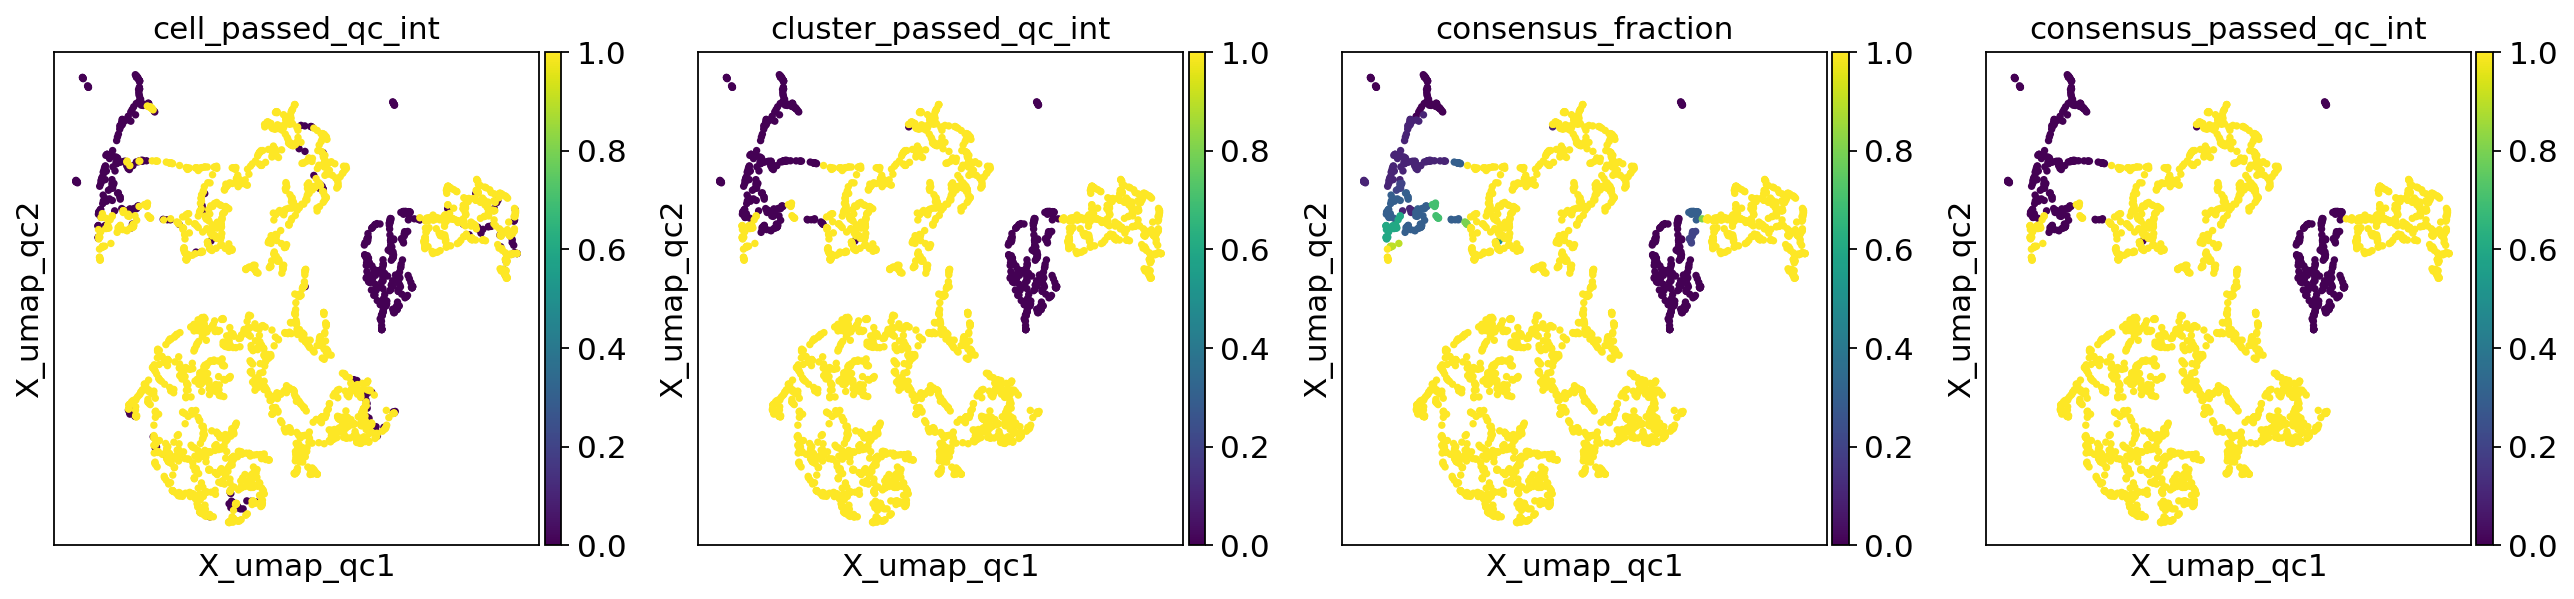

In [14]:
sctk.multi_resolution_cluster_qc(adata, metrics = metrics_list)

#this won't be necessary in scanpy 1.10.0, booleans will become directly plottable
for col in ['cell_passed_qc', 'cluster_passed_qc', 'consensus_passed_qc']:
    adata.obs[col+"_int"] = adata.obs[col].astype(int)
sc.pl.embedding(adata, "X_umap_qc", color=["cell_passed_qc_int", 
                                           "cluster_passed_qc_int", 
                                           "consensus_fraction", 
                                           "consensus_passed_qc_int"])

The plots align better now. The two sets of multi-clustering QC calls seem to agree pretty well as well.

At this point you should be able to use the QC workflow on your own data.